In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
import utils
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
import importlib

importlib.reload(utils)

<module 'utils' from '/home/mtemoschenko/TFE/utils.py'>

<h3> Load Training Model </h3>
<h6> Model used to generate samples</h6>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    #"activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : 24,
'context' : 4,
'embedding' : 64}
CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
path_data = 'data/processed'
path_model = 'slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_600.pth'
setup = utils.load_setup(CONFIG, path_data, path_model, device)

Using device: cuda


/home/mtemoschenko/TFE/utils.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_600.pth, trained until epoch 600


In [4]:
batch, dic = next(iter(setup['validloader']))
c = dic['context'].to(device)

<h3>Load Classifier</h3>

In [5]:
from TFE.metric.model import *
efficient_net = EfficientNet()
checkpoint_eff_path = 'efficientnet_finetuned.pth'
checkpoint = torch.load(checkpoint_eff_path, map_location='cpu', weights_only=True)
efficient_net.load_state_dict(checkpoint)
label = ['p(x)','samples']

In [6]:
efficient_net.eval()
with torch.no_grad():
    output = efficient_net(batch.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} \%")

p(x) with 99.48947143554688 \%
p(x) with 85.93675231933594 \%
p(x) with 99.96766662597656 \%
p(x) with 100.0 \%
p(x) with 100.0 \%
p(x) with 99.90650939941406 \%
p(x) with 99.99996185302734 \%
p(x) with 99.96595764160156 \%
p(x) with 99.89268493652344 \%
p(x) with 99.99982452392578 \%
p(x) with 98.3232421875 \%
p(x) with 100.0 \%
p(x) with 90.26763916015625 \%
p(x) with 99.9415054321289 \%
p(x) with 92.10008239746094 \%
p(x) with 99.99996185302734 \%
p(x) with 98.60009765625 \%
p(x) with 99.99736785888672 \%
p(x) with 96.11809539794922 \%
p(x) with 82.3016128540039 \%
p(x) with 99.97871398925781 \%
p(x) with 99.99413299560547 \%
p(x) with 99.90838623046875 \%
p(x) with 99.96151733398438 \%
p(x) with 99.7681884765625 \%
p(x) with 99.96881103515625 \%
p(x) with 99.99639129638672 \%
p(x) with 100.0 \%
samples with 62.238399505615234 \%
p(x) with 100.0 \%
p(x) with 99.99993896484375 \%
p(x) with 99.99554443359375 \%
p(x) with 98.17208099365234 \%
p(x) with 99.6968002319336 \%
p(x) with 99.

<h3> Load Validation Model </h3>
<h4> Model not used while generating samples to train the classifier </h4>
<h4> Assess the performence of the model using an external Classifier </h4>

In [7]:
# Evaluate other model
importlib.reload(utils)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    #"activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128, 256, 512, 1024],
'attention_levels' : [4],
'hidden_blocks' : [2,3,3,3,3],
'spatial' : 2,
'channels' : 24,
'context' : 5,
'embedding' : 64}
CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
path_data = 'data/processed'
path_model = 'checkpoints/giddy-pond-83_1tshliqd/model_290.pth'
giddy_pond_setup = utils.load_setup(CONFIG, path_data, path_model, device, date_embedding=True, multi_gpu=True)

Using device: cuda


/home/mtemoschenko/TFE/utils.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded Date Embedding
Model restored from checkpoints/giddy-pond-83_1tshliqd/model_290.pth, trained until epoch 290


In [8]:
giddy_pond_batch, giddy_pond_dic = next(iter(giddy_pond_setup['validloader']))
frac_time = lambda day, hour: (day/365, hour/23)
giddy_pond_dic['frac_day_of_year'][:], giddy_pond_dic['frac_hour_of_day'][:] = frac_time(182,0)
c = utils.constructEmbedding(giddy_pond_setup['date_embedding'], giddy_pond_dic).to(device)
c = c[0].unsqueeze(0).repeat(100,1,1,1)
print(c.shape)

torch.Size([100, 5, 64, 64])


In [9]:
giddy_pond_samples = giddy_pond_setup['vpsde'].sample(giddy_pond_setup['mask'],c=c[:100],shape=(100,),steps=256, corrections=8)

hello


100%|█████████████████████████████████████████████████| 256/256 [09:05<00:00,  2.13s/it]


torch.Size([100, 24, 64, 64])
T2m  Mean : 8.182408332824707, Var: 2.0258824825286865
U10m  Mean : 1.5392439365386963, Var: 1.8435794115066528
T2m  Mean : 7.295201301574707, Var: 2.495208978652954
U10m  Mean : 1.6527469158172607, Var: 2.2539594173431396
T2m  Mean : 8.143387794494629, Var: 2.2646024227142334
U10m  Mean : 1.5896052122116089, Var: 1.7115541696548462
T2m  Mean : 7.750332832336426, Var: 2.2860639095306396
U10m  Mean : 1.627135157585144, Var: 2.098719835281372
T2m  Mean : 6.958059787750244, Var: 2.590688705444336
U10m  Mean : 1.4858111143112183, Var: 1.5993893146514893
T2m  Mean : 11.519774436950684, Var: 3.1850473880767822
U10m  Mean : 1.525080919265747, Var: 2.093404531478882
T2m  Mean : 9.80269718170166, Var: 2.502342939376831
U10m  Mean : 2.087761640548706, Var: 2.307614803314209
T2m  Mean : 9.560395240783691, Var: 2.9468483924865723
U10m  Mean : 1.759671926498413, Var: 2.209618091583252


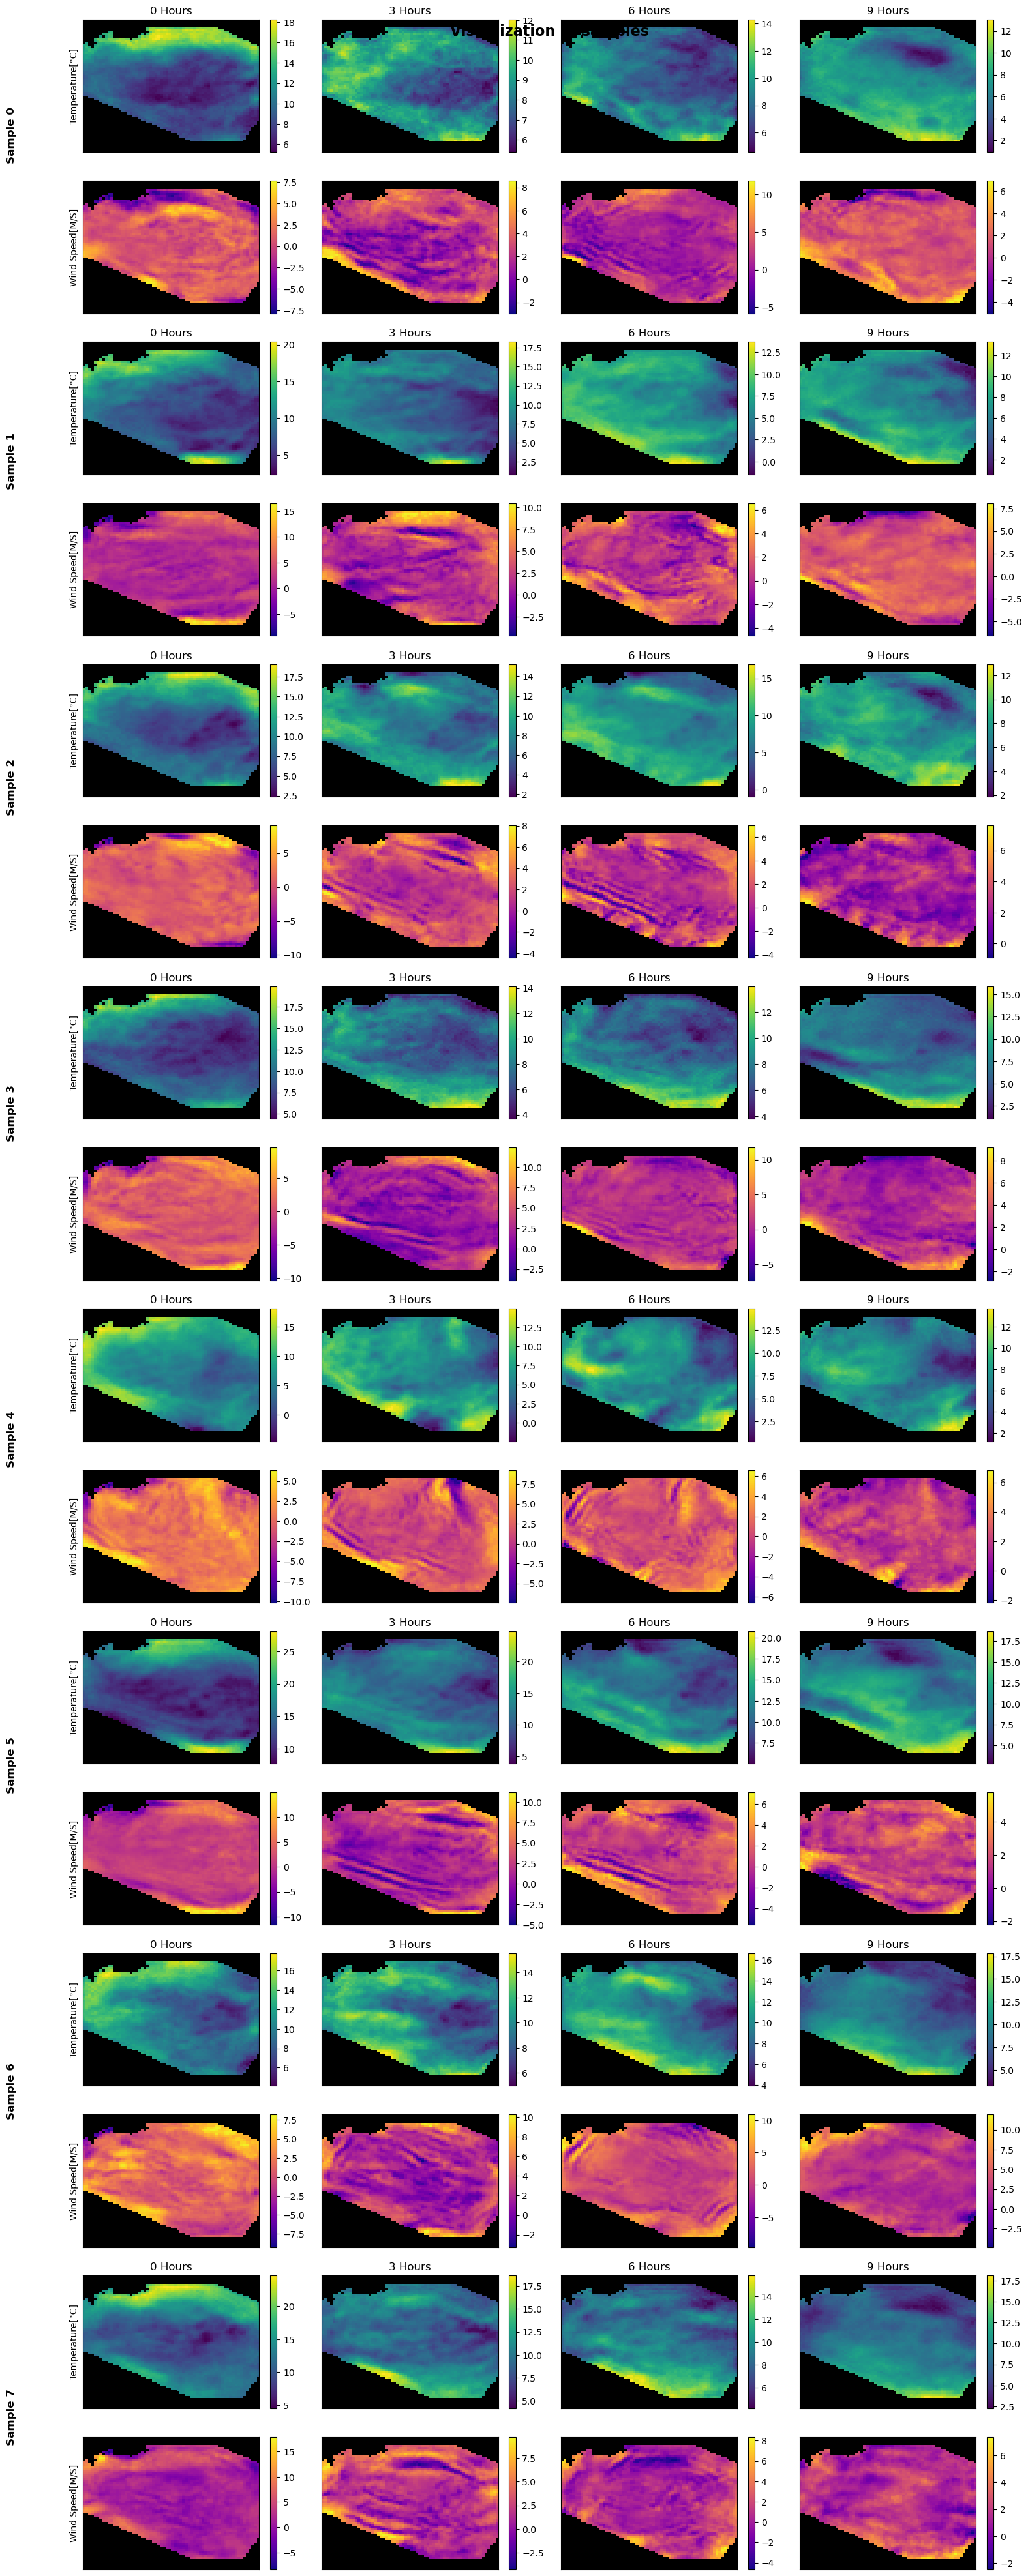

In [10]:

sample_cpu = giddy_pond_samples.detach().cpu()
PATH = Path('.')
path_unnorm = PATH / "data/processed/train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sample_cpu,info,giddy_pond_setup['mask_cpu'],samples=8,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [11]:
efficient_net.eval()
with torch.no_grad():
    output = efficient_net(giddy_pond_batch.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} \%")

p(x) with 99.16595458984375 \%
p(x) with 100.0 \%
p(x) with 99.83284759521484 \%
p(x) with 98.87430572509766 \%
p(x) with 99.96401977539062 \%
samples with 51.86537551879883 \%
p(x) with 99.83069610595703 \%
p(x) with 99.8052749633789 \%
p(x) with 99.79279327392578 \%
samples with 98.17969512939453 \%
samples with 90.67406463623047 \%
p(x) with 56.175804138183594 \%
p(x) with 99.26933288574219 \%
samples with 50.593597412109375 \%
p(x) with 71.69204711914062 \%
p(x) with 99.99647521972656 \%
p(x) with 99.9837875366211 \%
samples with 83.67335510253906 \%
samples with 99.92928314208984 \%
p(x) with 99.99964141845703 \%
p(x) with 86.39969635009766 \%
p(x) with 74.94728088378906 \%
p(x) with 100.0 \%
samples with 65.93019104003906 \%
p(x) with 81.87335968017578 \%
p(x) with 99.99991607666016 \%
p(x) with 99.99995422363281 \%
p(x) with 100.0 \%
p(x) with 99.5893325805664 \%
p(x) with 94.31221008300781 \%
p(x) with 99.9178466796875 \%
samples with 99.94953918457031 \%
p(x) with 100.0 \%
p(x

In [ ]:
efficient_net.eval()
with torch.no_grad():
    output = efficient_net(giddy_pond_samples.detach().cpu())
    prob = torch.nn.functional.softmax(output, dim=1)
    _, preds = torch.max(output, 1)
    samples_accuracy = (preds == 1).sum().item() / len(preds) * 100
    print(f"Accuracy on generated samples: {samples_accuracy:.2f}%")    
    print("Results on generated samples:")
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100:.2f}%")
    print("\nResults on original batch:")
    output_orig = efficient_net(giddy_pond_batch.cpu()[:100])
    prob_orig = torch.nn.functional.softmax(output_orig, dim=1)
    _, preds_orig = torch.max(output_orig, 1)
    original_accuracy = (preds_orig == 0).sum().item() / len(preds_orig) * 100
    print(f"Accuracy on original batch: {original_accuracy:.2f}%")
    for i in range(len(preds_orig)):
        print(f"{label[preds_orig[i]]} with {prob_orig[i,preds_orig[i]]*100:.2f}%")

Accuracy on generated samples: 100.00%
Results on generated samples:
samples with 99.98%
samples with 99.97%
samples with 99.99%
samples with 100.00%
samples with 99.87%
samples with 99.82%
samples with 98.35%
samples with 99.98%
samples with 99.99%
samples with 100.00%
samples with 100.00%
samples with 100.00%
samples with 100.00%
samples with 100.00%
samples with 99.99%
samples with 99.97%
samples with 100.00%
samples with 99.17%
samples with 100.00%
samples with 100.00%
samples with 99.16%
samples with 99.99%
samples with 100.00%
samples with 99.99%
samples with 100.00%
samples with 99.08%
samples with 99.98%
samples with 100.00%
samples with 100.00%
samples with 99.42%
samples with 86.47%
samples with 99.93%
samples with 100.00%
samples with 99.98%
samples with 99.98%
samples with 99.99%
samples with 100.00%
samples with 99.99%
samples with 100.00%
samples with 99.98%
samples with 99.94%
samples with 95.10%
samples with 98.24%
samples with 100.00%
samples with 99.95%
samples with 9